In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Tue Nov 24 09:01:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import random
from PIL import Image, ImageOps


def to_list(file_dir, file_name):
    tif_obj = Image.open(os.path.join(file_dir, file_name))
    data = []
    for i in range(tif_obj.n_frames):
        tif_obj.seek(i)
        data.append(Image.fromarray(np.array(tif_obj)))
    return data



class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        file_dir = "/content/drive/My Drive/isbi2012"
        self.input = to_list(file_dir, "train-volume.tif")
        self.label = to_list(file_dir, "train-labels.tif")
        self.test = to_list(file_dir, "test-volume.tif")
        self.mean = np.array([np.array(img) for img in self.input]).mean()
        self.stddev = np.array([np.array(img) for img in self.input]).std()
    
    def __len__(self):
        return len(self.input)
   
    def __getitem__(self, idx):
        num_rotate = np.random.randint(0, 4)
        input = self.input[idx]
        label = self.label[idx]
        num_rotate = np.random.randint(0, 4)
        input = input.rotate(90 * num_rotate)
        label = label.rotate(90 * num_rotate)
        if np.random.rand() > 0.5:
            input = ImageOps.flip(input)
            label = ImageOps.flip(label)
        input = (torch.from_numpy(np.array(input).astype(np.float32)).unsqueeze(0) - self.mean) / self.stddev
        label = torch.from_numpy(np.array(label).astype(np.float32)).unsqueeze(0) / 255.
        return input, label

    def get_test(self, idx):
        return (torch.from_numpy(np.array(self.test[idx]).astype(np.float32)).unsqueeze(0) - self.mean) / self.stddev


dataset = DataSet()
mb_size = 5
loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True, drop_last=True)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        ).to(device)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2)).to(device)

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        ).to(device)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2)).to(device)

        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        ).to(device)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2)).to(device)

        self.enc4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        ).to(device)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2)).to(device)

        self.root = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        ).to(device)

        self.dec4 = nn.Sequential(
            nn.Conv2d(in_channels=2 * 512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        ).to(device)

        self.dec3 = nn.Sequential(
            nn.Conv2d(in_channels=2 * 256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        ).to(device)


        self.dec2 = nn.Sequential(
            nn.Conv2d(in_channels=2 * 128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        ).to(device)

        self.dec1 = nn.Sequential(
            nn.Conv2d(in_channels=2 * 64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=True),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        ).to(device)



    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        root = self.root(self.pool4(enc4))
        root = self.dec4(torch.cat([root, enc4], dim=1))
        root = self.dec3(torch.cat([root, enc3], dim=1))
        root = self.dec2(torch.cat([root, enc2], dim=1))
        root = self.dec1(torch.cat([root, enc1], dim=1))
        return root

In [15]:
unet = UNet()
fn_loss = nn.BCEWithLogitsLoss().to(device)
solver = optim.Adam(unet.parameters(), lr=1e-6)

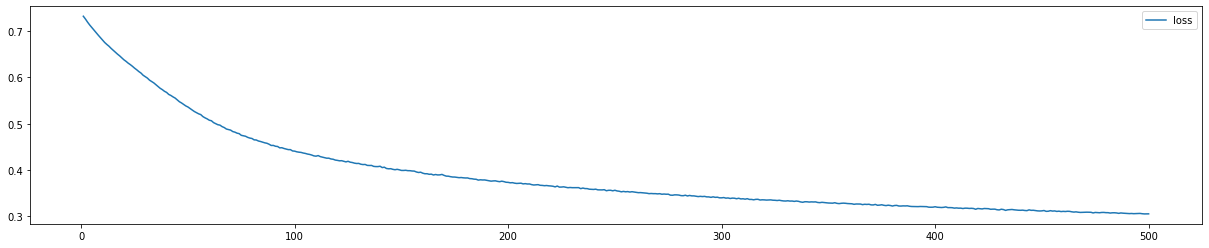

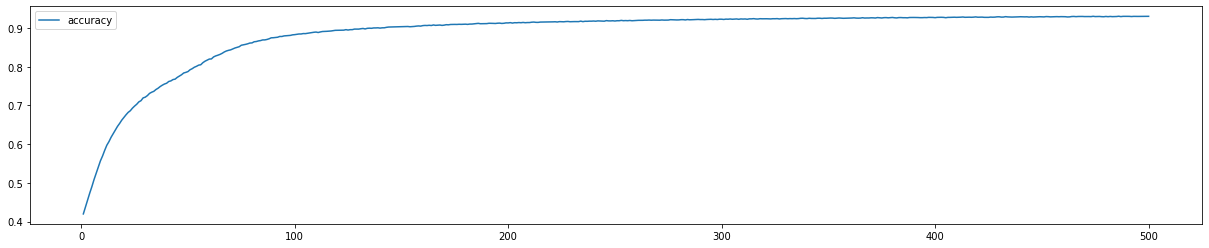

In [16]:
train_loss = []
train_accuracy = [] 
num_epochs = 500
for epoch in range(num_epochs):
    LOSS = 0.0
    ACC = 0.0
    for _, (input, label) in enumerate(loader):
        input = input.to(device)
        label = label.to(device)
        solver.zero_grad()
        output = unet(input)
        loss = fn_loss(output, label)
        loss.backward()
        solver.step()
        with torch.no_grad():
            output = torch.sigmoid(output)
            output = 1 * (output > 0.5)
            ACC +=  (1.0 - (output - label).abs().mean())
            LOSS += loss.item()
    train_loss.append(LOSS / len(loader))
    train_accuracy.append(ACC / len(loader))

plt.figure(figsize=(21, 4))
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='loss')
plt.legend()
plt.show()

plt.figure(figsize=(21, 4))
plt.plot(np.arange(1, len(train_accuracy) + 1), train_accuracy, label='accuracy')
plt.legend()
plt.show()

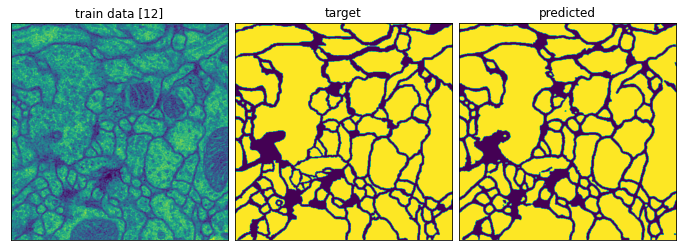

In [17]:
with torch.no_grad():
    
    fig = plt.figure(figsize=(12, 4))
    idx = random.randint(0, len(dataset.input) - 1)
    input, label = dataset.__getitem__(idx)
    pred = torch.sigmoid(unet(input.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    pred = 1.0 * (pred > 0.5)
    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    ax.set_title('train data [' + str(idx) + ']')
    ax.imshow(input.squeeze())
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    ax.set_title('target')
    ax.imshow(label.squeeze())
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    ax.set_title('predicted')
    ax.imshow(pred)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()


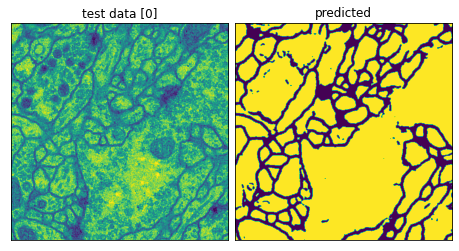

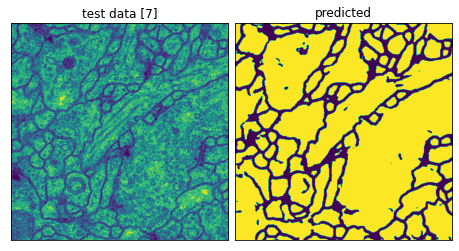

In [22]:
with torch.no_grad():

    fig = plt.figure(figsize=(8, 4))
    idx = random.randint(0, len(dataset.test) - 1)    
    input = dataset.get_test(idx)
    pred = torch.sigmoid(unet(input.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    pred = 1.0 * (pred > 0.5)
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('test data [' + str(idx) + ']')
    ax.imshow(input.squeeze())
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('predicted')
    ax.imshow(pred)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()

    fig = plt.figure(figsize=(8, 4))
    idx = random.randint(0, len(dataset.test) - 1)    
    input = dataset.get_test(idx)
    pred = torch.sigmoid(unet(input.unsqueeze(0).to(device))).squeeze().cpu().detach().numpy()
    pred = 1.0 * (pred > 0.5)
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.set_title('test data [' + str(idx) + ']')
    ax.imshow(input.squeeze())
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    ax.set_title('predicted')
    ax.imshow(pred)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()


In [23]:
print('https://github.com/hanyoseob/youtube-cnn-002-pytorch-unet')

https://github.com/hanyoseob/youtube-cnn-002-pytorch-unet
